This page was created from a Jupyter notebook. The original notebook can be found [here](https://github.com/klane/databall/blob/master/notebooks/parameter-tuning.ipynb). It investigates tuning model parameters to achieve better performance. First we must import the necessary installed modules.

In [1]:
import itertools
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

The code below simply customizes font sizes for all the plots that follow.

In [2]:
plt.rc('font', size=14)        # controls default text sizes
plt.rc('axes', titlesize=16)   # fontsize of the axes title
plt.rc('axes', labelsize=16)   # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)  # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  # fontsize of the tick labels
plt.rc('legend', fontsize=14)  # legend fontsize

We can then load the datasets saved during [feature selection](feature-selection.md) to ensure the same train/test split is used.

In [3]:
f = open('databall.pkl')
X, X_train, X_test, y, y_train, y_test = pickle.load(f)
f.close()

# Define Functions

Before we can tune model parameters we need to define a few functions to assist us. The first one calculates a number of cross validated metrics using [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).

In [4]:
def evaluate_model(model, X, y, k=6):
    # Define metrics
    scoring = ['accuracy', 'precision', 'recall', 'roc_auc', 'average_precision']
    
    # Create cross validator
    kfold = StratifiedKFold(n_splits=k)
    
    # Calculate metrics
    return [cross_val_score(model, X, y, cv=kfold, scoring=score).mean() for score in scoring]

The function below provides a generic way to calculate performance metrics for models of a given type with different values for one of the algorithm's parameters. The models that are input are actually functions generated with `partial` that return a model using the specified parameters.

In [5]:
def get_metrics(models, attributes, param_name, param_vec):
    # Initialize list of results
    results = [[] for m in models]
    
    # Make transformer that selects the desired attributes from the DataFrame
    selector = FunctionTransformer(partial(select_columns, names=attributes))
    
    for i in range(len(models)):
        for param in param_vec:
            # Make a pipeline that selects the desired attributes prior to the classifier
            model = make_pipeline(selector, models[i](**{param_name: param}))
            
            # Calculate performance metrics
            results[i] += [evaluate_model(model, X_train, y_train)]
    
    return results

The following function plots the calculated metrics in a grid to easily visualize their distributions with the varied parameter.

In [6]:
def plot_metrics(x, y, xlabel, legend, legendsize=14, figsize=(16, 8), log=False):
    rows = 2
    cols = 3
    ylabel = ['Accuracy', 'Precision', 'Recall', 'ROC Area', 'Precision/Recall Area']
    plt.figure(figsize=figsize)
    
    for i in range(0,len(y[0][0])):
        ax = plt.subplot(100*rows + 10*cols + i + 1)
        
        if log:
            [ax.semilogx(x, [yvec[i] for yvec in y[j]]) for j in range(0,len(y))]
        else:
            [ax.plot(x, [yvec[i] for yvec in y[j]]) for j in range(0,len(y))]
            ax.set_xlim(0)
        
        ax.set_ylim(0, 1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel[i])
        ax.legend(legend, fontsize=legendsize)
    
    plt.tight_layout()
    plt.show()

The final function is repeated from the [feature selection](feature-selection.md) notebook and selects columns from a `DataFrame`.

In [7]:
def select_columns(df, names, columns=X_train.columns):
    return df[:, [i for i, col in enumerate(columns) if any(n in col for n in names)]]

# Logistic Regression

The plots below show `LogisticRegression` model performance using different combinations of three parameters: `penalty` (type of norm), `class_weight` (where "balanced" indicates weights are inversely proportional to class frequencies and the default is one), and `dual` (flag to use the dual formulation). For each combination, models were trained with different `C` values, which controls the inverse of the regularization strength.

All models have similar accuracy, ROC area, and precision/recall area up to a `C` value of about 3, at which point the models using the dual formulation have degraded performance. Setting `class_weight` to "balanced" raises model precision slightly in most cases, but dramatically reduces recall. None of the models perform noticeably better than the default `LogisticRegression` model.

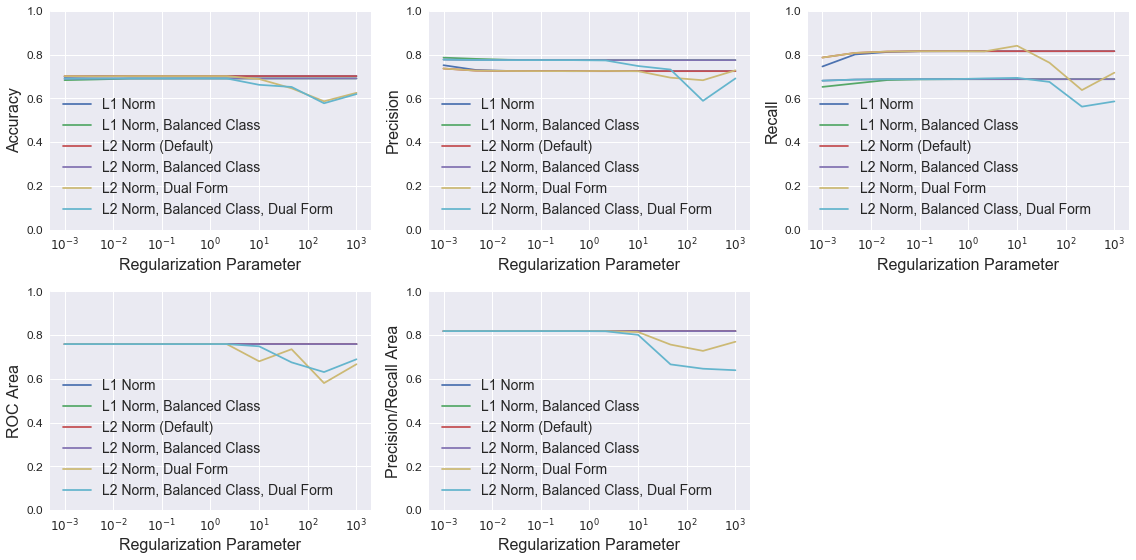

In [8]:
# Create functions that return logistic regression models with different parameters
models = [partial(LogisticRegression, penalty='l1'),
          partial(LogisticRegression, penalty='l1', class_weight='balanced'),
          partial(LogisticRegression),
          partial(LogisticRegression, class_weight='balanced'),
          partial(LogisticRegression, dual=True),
          partial(LogisticRegression, class_weight='balanced', dual=True)]

C_vec = np.logspace(start=-3, stop=3, num=10)
results = get_metrics(models, ['SRS'], 'C', C_vec)
legend = ['L1 Norm', 'L1 Norm, Balanced Class', 'L2 Norm (Default)',
          'L2 Norm, Balanced Class', 'L2 Norm, Dual Form', 'L2 Norm, Balanced Class, Dual Form']
plot_metrics(C_vec, results, 'Regularization Parameter', legend, log=True)

# Support Vector Machine

The [`LinearSVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) class is similar to a generic [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) with a linear kernel, but is implemented with liblinear instead of libsvm. The documentation states that `LinearSVC` scales better to large sample sizes since `SVC`'s fit time complexity is more than quadratic with the number of samples. I initially tried `SVC`, but the training time was too costly. `LinearSVC` proved to be must faster for this problem.

The plots below show `LinearSVC` model performance using different combinations of four parameters: `penalty` (identical to `LogisticRegression`), `loss` (the loss function), `class_weight` (identical to `LogisticRegression`), and `dual` (identical to `LogisticRegression`). For each combination, models were trained with different `C` values, which controls the penalty of the error term.

Similar to above, all models have similar accuracy, ROC area, and precision/recall area up to a `C` value of about 10, at which point the models using the dual formulation have degraded performance. Again, setting `class_weight` to "balanced" raises model precision slightly in most cases, but dramatically reduces recall. None of the models perform noticeably better than the default `LinearSVC` model.

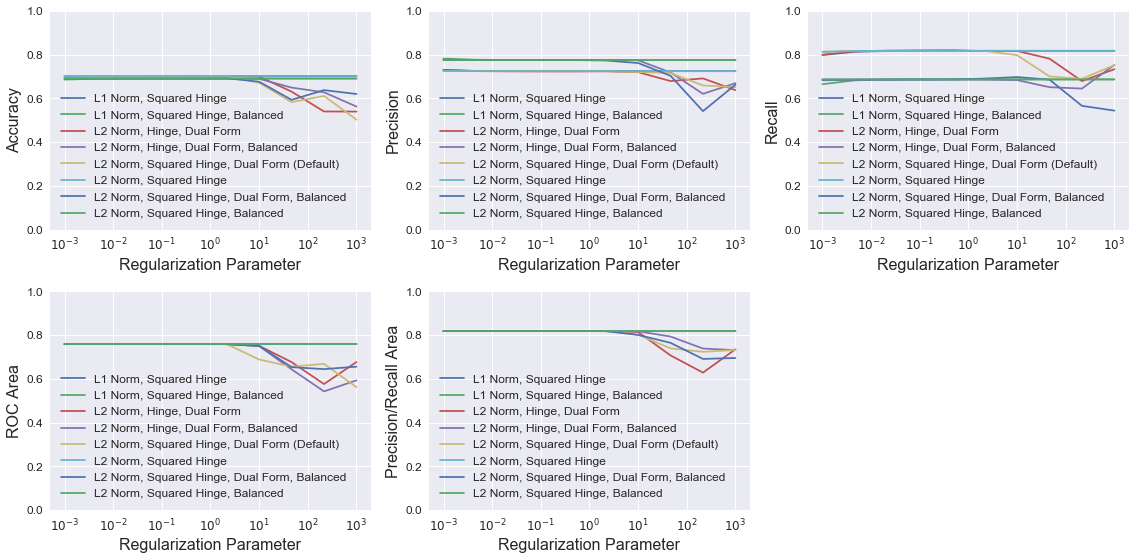

In [9]:
# Create functions that return support vector machines with different parameters
models = [partial(LinearSVC, penalty='l1', dual=False),
          partial(LinearSVC, penalty='l1', dual=False, class_weight='balanced'),
          partial(LinearSVC, loss='hinge'),
          partial(LinearSVC, loss='hinge', class_weight='balanced'),
          partial(LinearSVC),
          partial(LinearSVC, dual=False),
          partial(LinearSVC, class_weight='balanced'),
          partial(LinearSVC, dual=False, class_weight='balanced')]

C_vec = np.logspace(start=-3, stop=3, num=10)
results = get_metrics(models, ['SRS'], 'C', C_vec)
legend = ['L1 Norm, Squared Hinge', 'L1 Norm, Squared Hinge, Balanced', 'L2 Norm, Hinge, Dual Form',
          'L2 Norm, Hinge, Dual Form, Balanced', 'L2 Norm, Squared Hinge, Dual Form (Default)',
          'L2 Norm, Squared Hinge', 'L2 Norm, Squared Hinge, Dual Form, Balanced',
          'L2 Norm, Squared Hinge, Balanced']
plot_metrics(C_vec, results, 'Regularization Parameter', legend, legendsize=12, log=True)

# Random Forest

The plots below show [`RandomForestClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) model performance using different combinations of the parameters `class_weight` (identical to `LogisticRegression`) and `criterion` (function to evaluate split quality). For each combination, models were trained with different `n_estimators`, which controls the number of decision trees in the forest. Neither `criterion` nor `class_weight` have much impact on model performance. Performance improves with increased `n_estimators`, but performance quickly asymptotes at about 10 trees. None of the models perform noticeably better than the default `RandomForestClassifier` model.

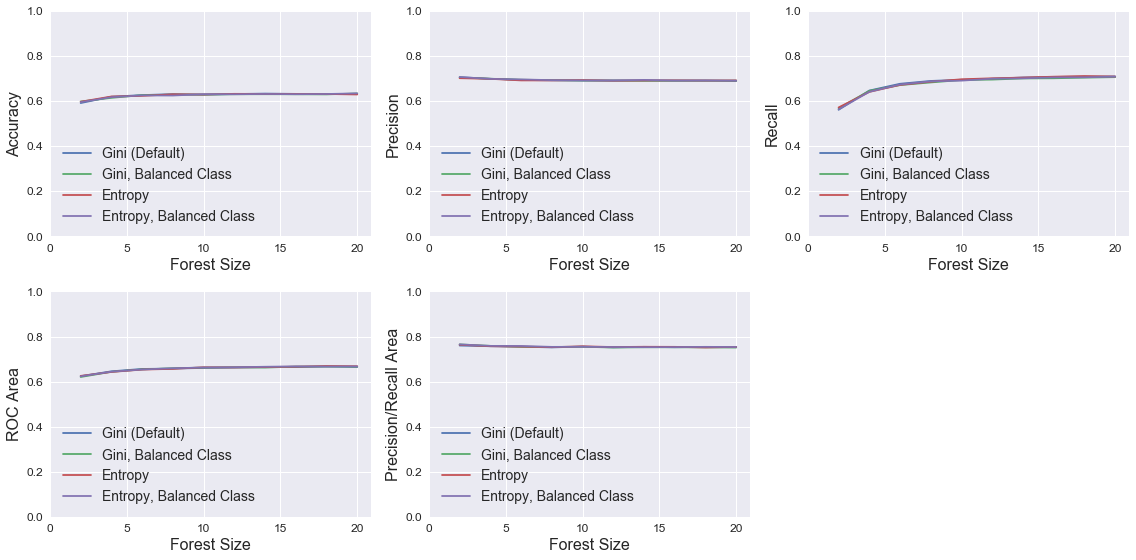

In [10]:
# Create functions that return random forest models with different parameters
models = [partial(RandomForestClassifier),
          partial(RandomForestClassifier, class_weight='balanced'),
          partial(RandomForestClassifier, criterion='entropy'),
          partial(RandomForestClassifier, criterion='entropy', class_weight='balanced')]

n_vec = range(2, 21, 2)
results = get_metrics(models, ['SRS'], 'n_estimators', n_vec)
legend = ['Gini (Default)', 'Gini, Balanced Class', 'Entropy', 'Entropy, Balanced Class']
plot_metrics(n_vec, results, 'Forest Size', legend)

# Neural Network

The plots below show [`MLPClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) model performance using different combinations of the parameters `hidden_layer_sizes` (number of neurons in each hidden layer) and `activation` (network activation function). For each combination, models were trained with different `alpha` values, which controls the L2 regularization similar to `LogisticRegression` and `LinearSVC`. All models have nearly identical performance until higher regularization strength. At high values of `alpha`, recall dramatically improves, but the other four metrics all worsen. None of the models perform noticeably better than the default `MLPClassifier` model.

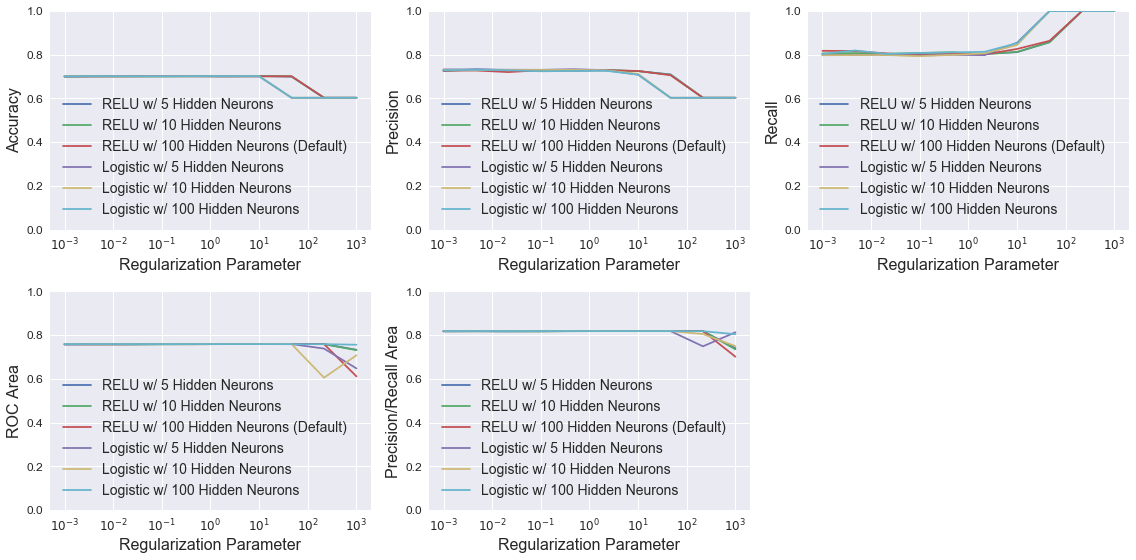

In [11]:
# Create functions that return neural networks with different parameters
models = [partial(MLPClassifier, hidden_layer_sizes=5),
          partial(MLPClassifier, hidden_layer_sizes=10),
          partial(MLPClassifier),
          partial(MLPClassifier, activation='logistic', hidden_layer_sizes=5),
          partial(MLPClassifier, activation='logistic', hidden_layer_sizes=10),
          partial(MLPClassifier, activation='logistic')]

alpha_vec = np.logspace(start=-3, stop=3, num=10)
results = get_metrics(models, ['SRS'], 'alpha', alpha_vec)
legend = ['RELU w/ 5 Hidden Neurons', 'RELU w/ 10 Hidden Neurons', 'RELU w/ 100 Hidden Neurons (Default)',
          'Logistic w/ 5 Hidden Neurons', 'Logistic w/ 10 Hidden Neurons', 'Logistic w/ 100 Hidden Neurons']
plot_metrics(alpha_vec, results, 'Regularization Parameter', legend, log=True)